In [99]:
import pandas as pd

credit_card = pd.read_csv('credit_default.csv')
credit_card = credit_card.drop('Unnamed: 0', axis=1)

new_header = credit_card.iloc[0]
credit_card = credit_card[1:]
credit_card.columns = new_header
credit_card = credit_card.rename(columns={'default payment next month': 'default'})

credit_card.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [100]:
credit_card.dtypes

0
LIMIT_BAL    object
SEX          object
EDUCATION    object
MARRIAGE     object
AGE          object
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1    object
BILL_AMT2    object
BILL_AMT3    object
BILL_AMT4    object
BILL_AMT5    object
BILL_AMT6    object
PAY_AMT1     object
PAY_AMT2     object
PAY_AMT3     object
PAY_AMT4     object
PAY_AMT5     object
PAY_AMT6     object
default      object
dtype: object

In [101]:
columns = credit_card.columns.tolist()

for col in columns:
    credit_card[col] = pd.to_numeric(credit_card[col])

In [102]:
credit_card['acum_debt_1'] = (credit_card['BILL_AMT1'] - credit_card['PAY_AMT1']) > 0
credit_card['acum_debt_2'] = (credit_card['BILL_AMT2'] - credit_card['PAY_AMT2']) + credit_card['acum_debt_1'] > 0
credit_card['acum_debt_3'] = (credit_card['BILL_AMT3'] - credit_card['PAY_AMT3']) + credit_card['acum_debt_2'] > 0
credit_card['acum_debt_4'] = (credit_card['BILL_AMT4'] - credit_card['PAY_AMT4']) + credit_card['acum_debt_3'] > 0
credit_card['acum_debt_5'] = (credit_card['BILL_AMT5'] - credit_card['PAY_AMT5']) + credit_card['acum_debt_4'] > 0
credit_card['acum_debt_6'] = (credit_card['BILL_AMT6'] - credit_card['PAY_AMT6']) + credit_card['acum_debt_5'] > 0

credit_card = credit_card.drop(columns=['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                                        'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'LIMIT_BAL', 'SEX', 'MARRIAGE'])

def age_classifier(x):
    if x < 40:
        return '<40'
    else:
        return '>=40'

credit_card['AGE'] = credit_card['AGE'].apply(age_classifier)

In [103]:
credit_card.iloc[0]

0
EDUCATION         2
AGE             <40
PAY_0             2
PAY_2             2
PAY_3            -1
PAY_4            -1
PAY_5            -2
PAY_6            -2
default           1
acum_debt_1    True
acum_debt_2    True
acum_debt_3    True
acum_debt_4    True
acum_debt_5    True
acum_debt_6    True
Name: 1, dtype: object

In [104]:
import pandas_profiling

profile = pandas_profiling.ProfileReport(credit_card, minimal=True)

# profile

In [105]:
import warnings
from causalnex.structure import StructureModel

warnings.filterwarnings('ignore')

sm = StructureModel()

In [106]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for column in credit_card.columns.tolist():
    credit_card[column] = le.fit_transform(credit_card[column])

In [107]:
credit_card.head()

,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,default,acum_debt_1,acum_debt_2,acum_debt_3,acum_debt_4,acum_debt_5,acum_debt_6
1,2,0,4,4,1,1,0,0,1,1,1,1,1,1,1
2,2,0,1,4,2,2,2,3,1,1,1,1,1,1,1
3,2,0,2,2,2,2,2,2,0,1,1,1,1,1,1
4,2,0,2,2,2,2,2,2,0,1,1,1,1,1,1
5,2,1,1,2,1,2,2,2,0,1,0,1,1,1,1


In [108]:
sm.add_edges_from([
    ('PAY_0', 'PAY_2'),
    ('PAY_2', 'PAY_3'),
    ('PAY_3', 'PAY_4'),
    ('PAY_4', 'PAY_5'),
    ('PAY_5', 'PAY_6'),
    ])

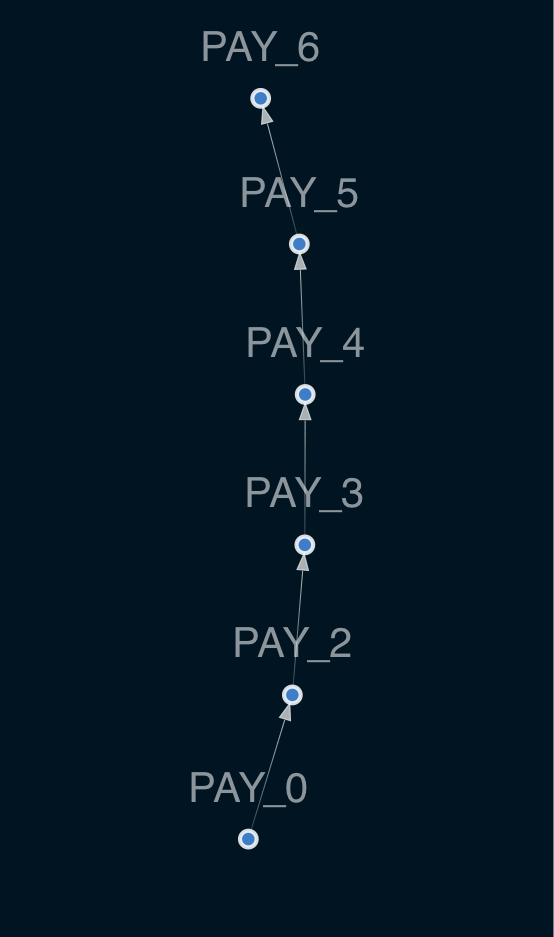

In [109]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK
)

Image(viz.draw(format='png'))

In [110]:
from causalnex.structure.notears import from_pandas

sm = from_pandas(credit_card)

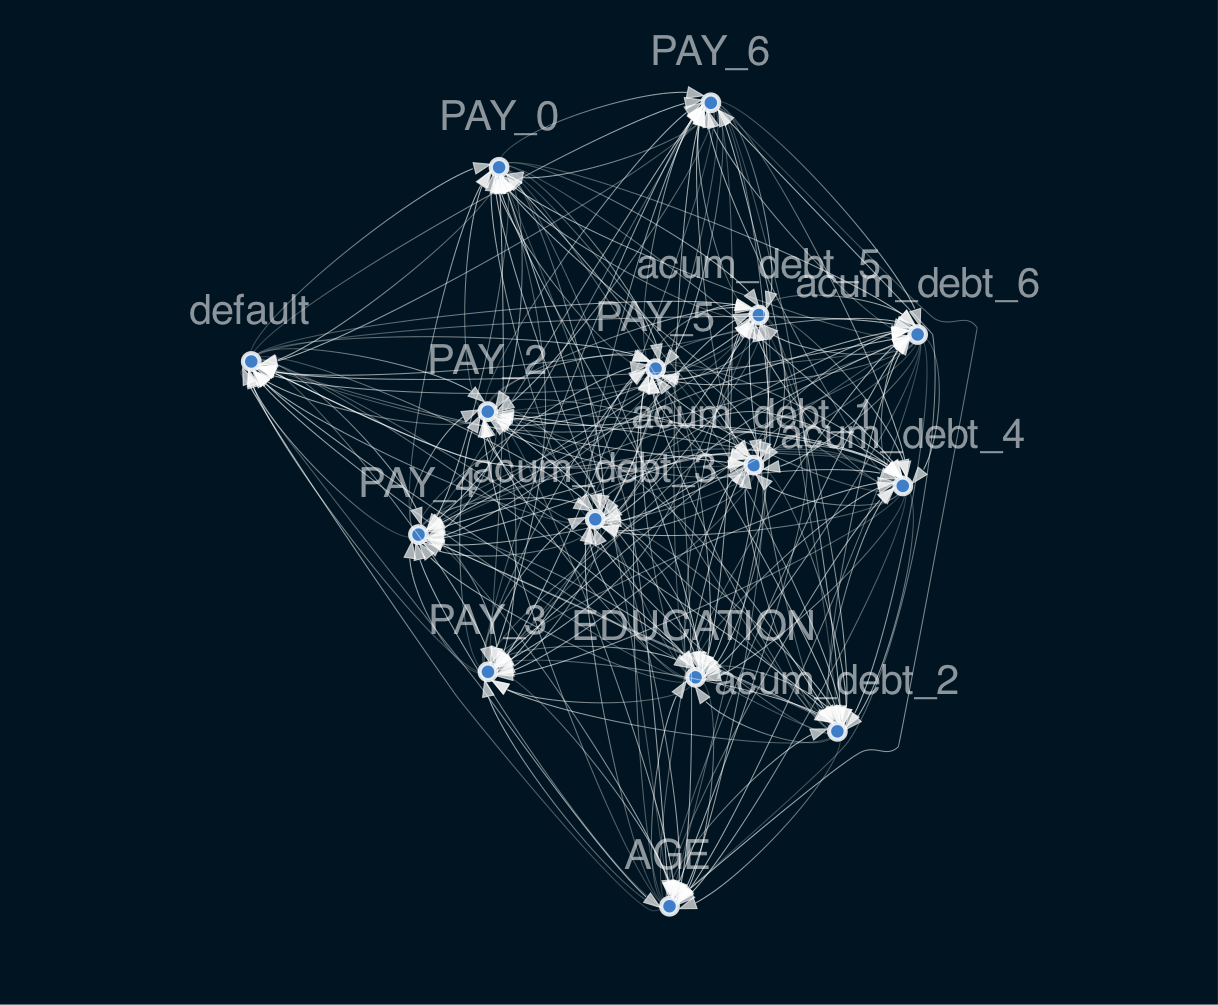

In [111]:
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_edge_attributes=EDGE_STYLE.WEAK,
    all_node_attributes=NODE_STYLE.WEAK,
    prog='fdp'
)

Image(viz.draw(format='png'))

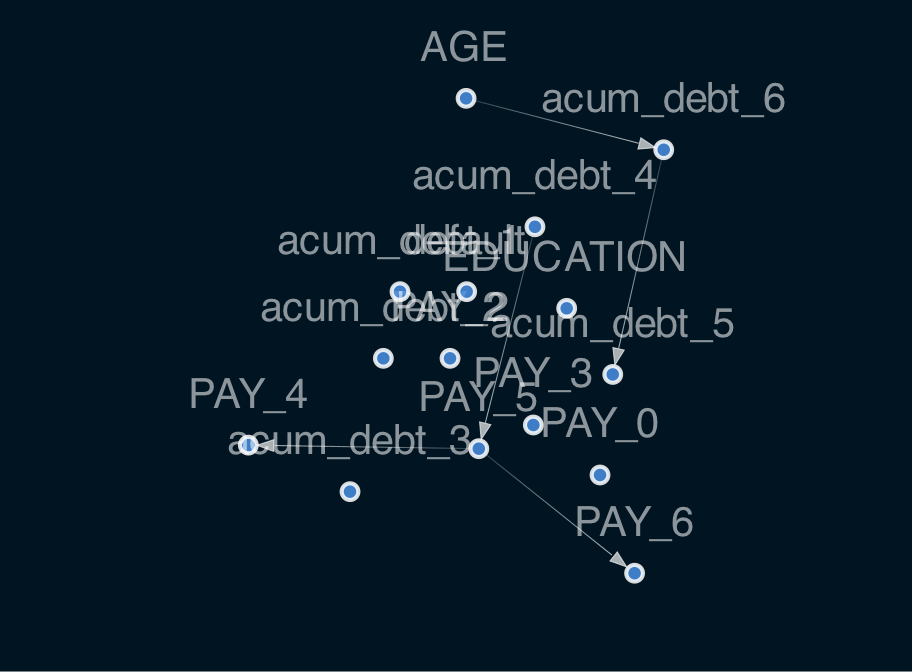

In [112]:
sm.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_edge_attributes=EDGE_STYLE.WEAK,
    all_node_attributes=NODE_STYLE.WEAK,
    prog='fdp'
)

Image(viz.draw(format='png'))

In [92]:
sm = from_pandas(credit_card, tabu_edges=[
    ('default', 'EDUCATION'), 
    ('default', 'PAY_0'),
    ('default', 'PAY_2'),
    ('default', 'PAY_3'),
    ('default', 'PAY_4'),
    ('default', 'PAY_5'),
    ('default', 'PAY_6')
    ], w_threshold=0.8)

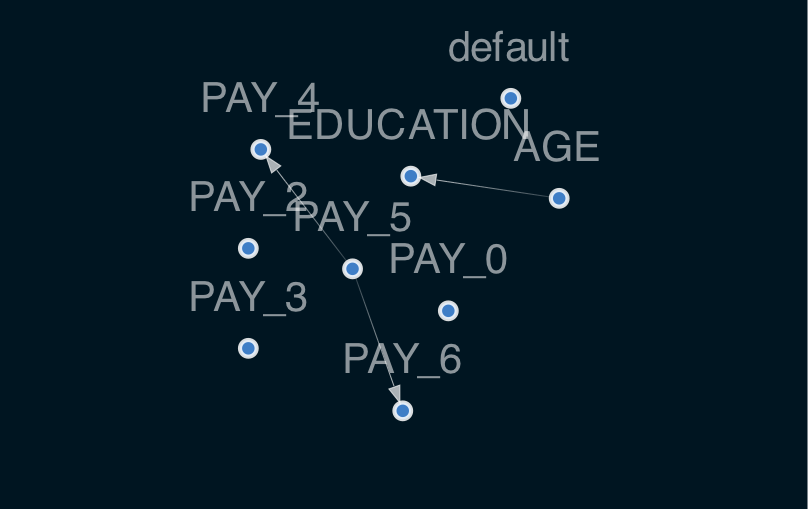

In [93]:
sm.remove_edges_below_threshold(0.8)

viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_edge_attributes=EDGE_STYLE.WEAK,
    all_node_attributes=NODE_STYLE.WEAK
)

Image(viz.draw(format='png'))

In [94]:
sm.add_edge('PAY_0', 'PAY_2')
sm.add_edge('PAY_2', 'PAY_3')
sm.add_edge('PAY_3', 'PAY_4')

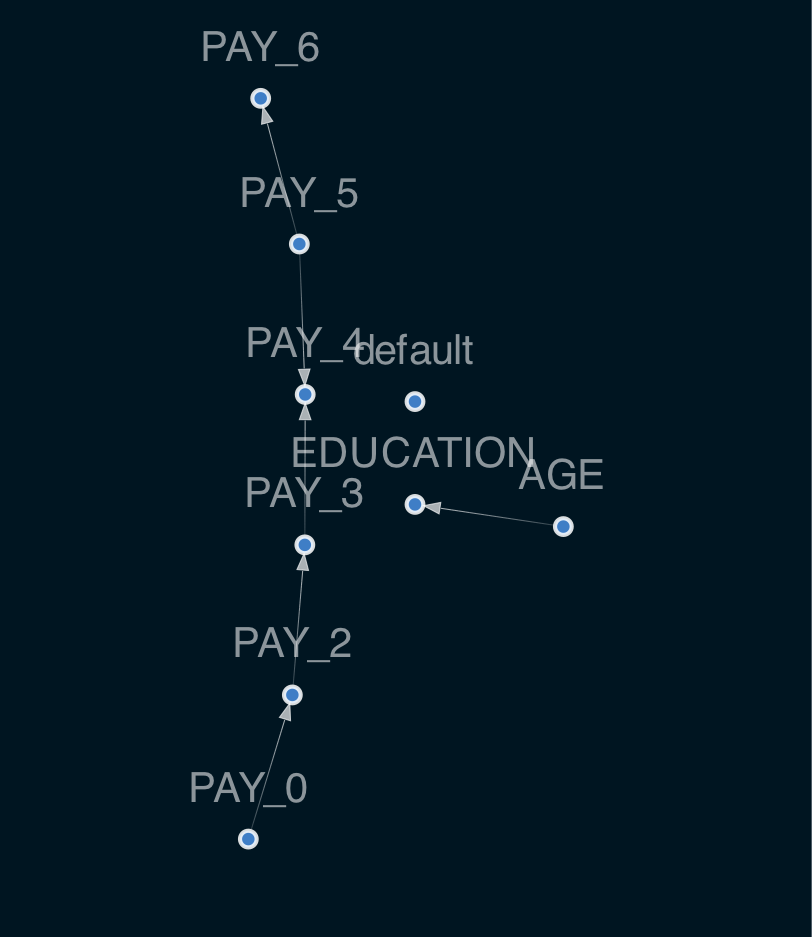

In [97]:
viz = plot_structure(
    sm,
    graph_attributes={'scale': '0.5'},
    all_edge_attributes=EDGE_STYLE.WEAK,
    all_node_attributes=NODE_STYLE.WEAK
)

Image(viz.draw(format='png'))

In [98]:
from causalnex.network import BayesianNetwork

bn = BayesianNetwork(sm)

ValueError: The given structure has 3 separated graph components. Please make sure it has only one.